Limited Rendering available only, to see the Charts please click on "external view available with nbviewer"

In [1]:
import numpy as np
import pandas as pd
import utils
import model
import plotly.graph_objects as go
from plotly.offline import init_notebook_mode
import warnings
warnings.filterwarnings("ignore")
init_notebook_mode()

In [2]:
dataframe = pd.read_csv("State_time_series.csv")
dataframe.Date=pd.to_datetime(dataframe.Date)
dataframe.index = dataframe.Date
dataframe['monthYear'] = pd.to_datetime(dataframe.index).to_period('M')
dataframe['year'] = dataframe.Date.dt.year

## Exploratory Data Analysis

In [3]:
utils.analysisChart(dataframe,'ZHVI_AllHomes','Zillow Home Index Value')

In [4]:
utils.analysisChart(dataframe,'PriceToRentRatio_AllHomes','Price to Rent Ratio')

In [5]:
utils.analysisChart(dataframe,'Sale_Counts','Sales Count')

In [6]:
utils.analysisChart(dataframe,'ZHVIPerSqft_AllHomes', 'House Value Index')

Guess which State is common across all the above charts. California! Would you invest in California or do you think the market is overly saturated?

In [7]:
fig = go.Figure()
fig.add_trace(go.Scatter(x = dataframe['Date'], y = dataframe['PctOfHomesSellingForGain_AllHomes'], name = 'Selling Gain',mode='lines'))
fig.add_trace(go.Scatter(x = dataframe['Date'], y = dataframe['PctOfHomesSellingForLoss_AllHomes'], name = 'Selling Loss',mode='lines'))
annotations = []       
fig.update_layout(
        xaxis=dict(
            showline=True,
            showgrid=False,
            showticklabels=True,
            linecolor='rgb(204, 204, 204)',
            linewidth=2,
            ticks='outside',
            tickfont=dict(
                family='Arial',
                size=12,
                color='rgb(82, 82, 82)',
            ),
        ),

        autosize=True,
        margin=dict(
            autoexpand=True,
            l=20,
            r=20,
            t=110,
        ),
        showlegend=True
    )


# Title
annotations.append(dict(xref='paper', yref='paper', x=0.0, y=1.10,
                              xanchor='left', yanchor='bottom',
                              text='Percentage Gain vs Loss Sold of Home',
                              font=dict(family='Arial',
                                        size=30,
                                        color='rgb(37,37,37)'),
                              showarrow=False))
fig.update_layout(annotations=annotations)

fig.show()

- Really love this chart. This is a comparison of the number of house listed that are sold for a higher price compared with listing price vs lower price compared with listing price.
- After the 2008 financial crisis, the percentage of house selling for above asking price decreased, and the percentage of house selling for lower than asking price increased.
- The trend has been reversing after 2012

## Data Preprocessing

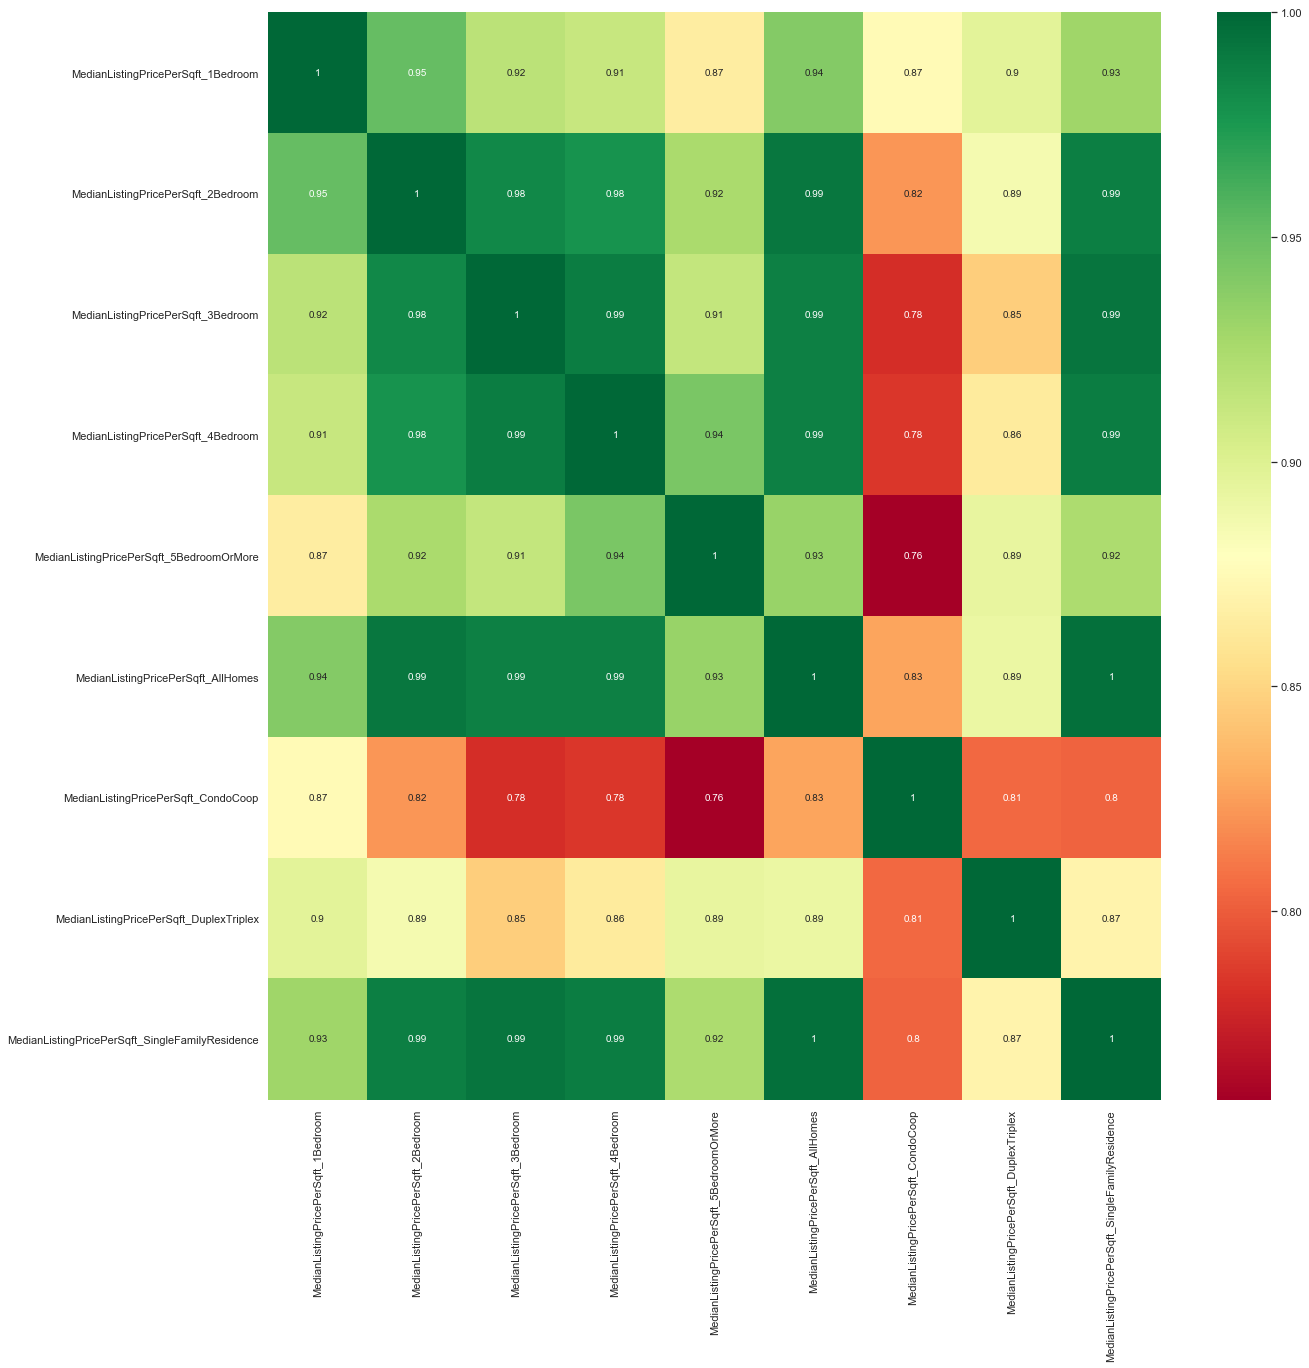

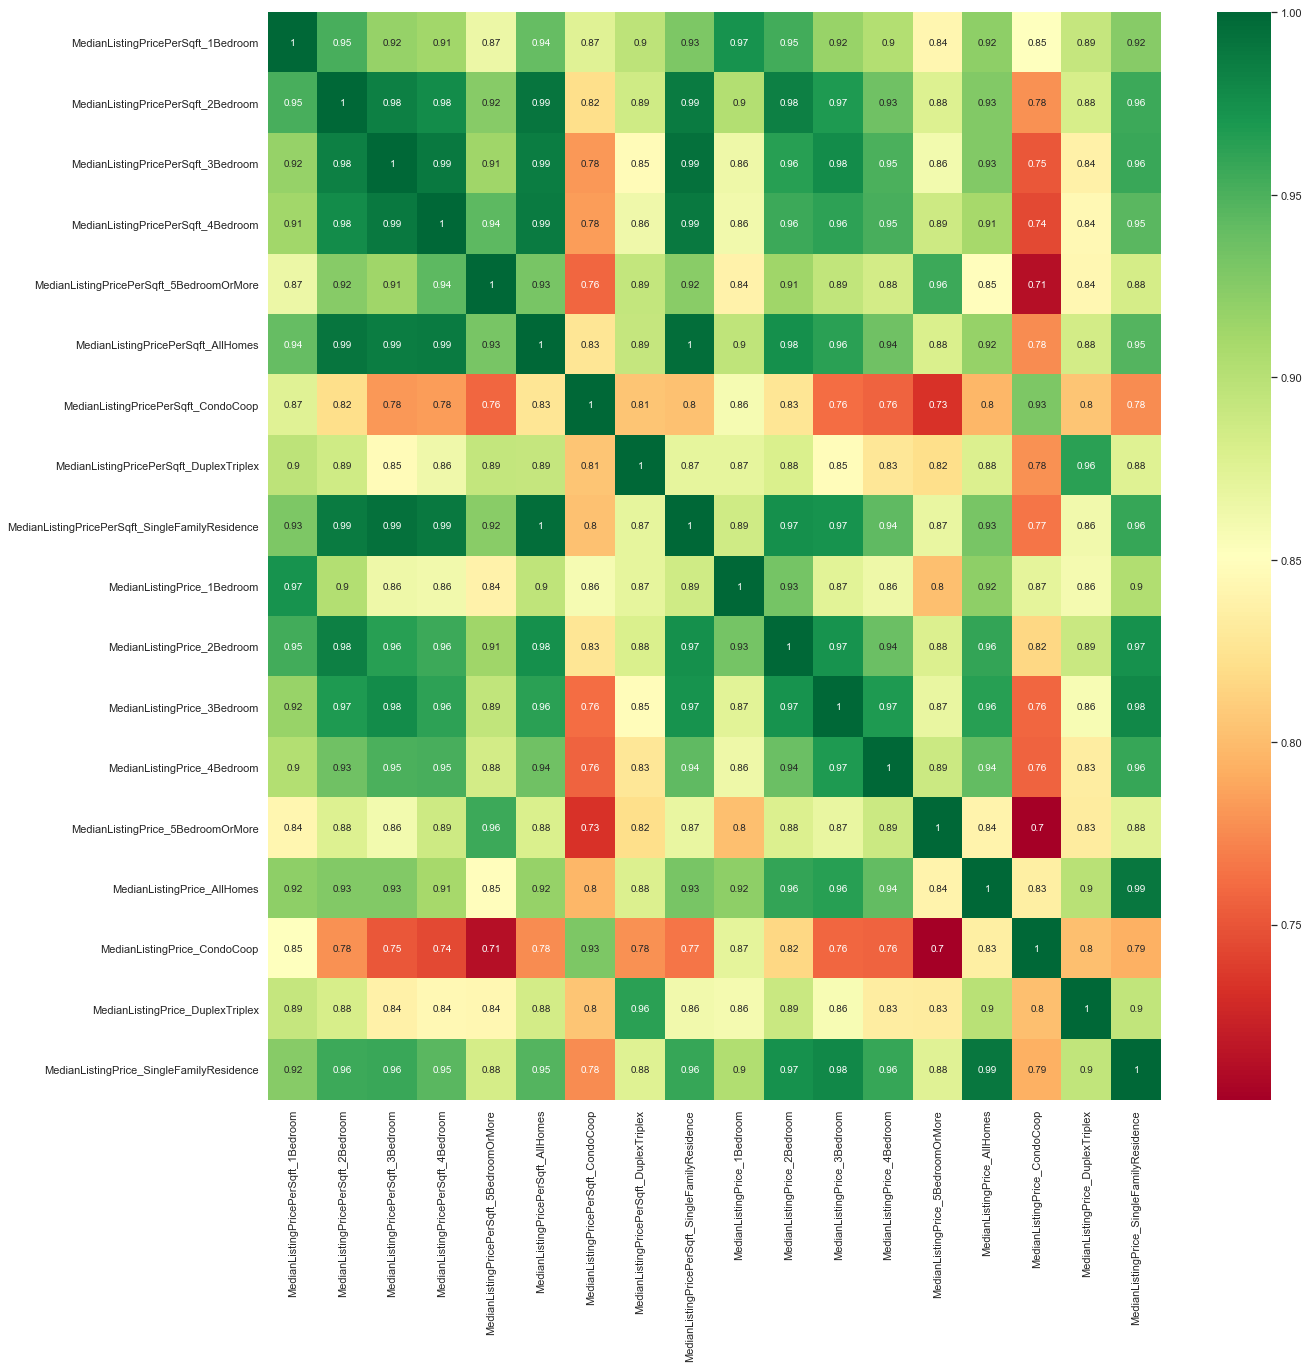

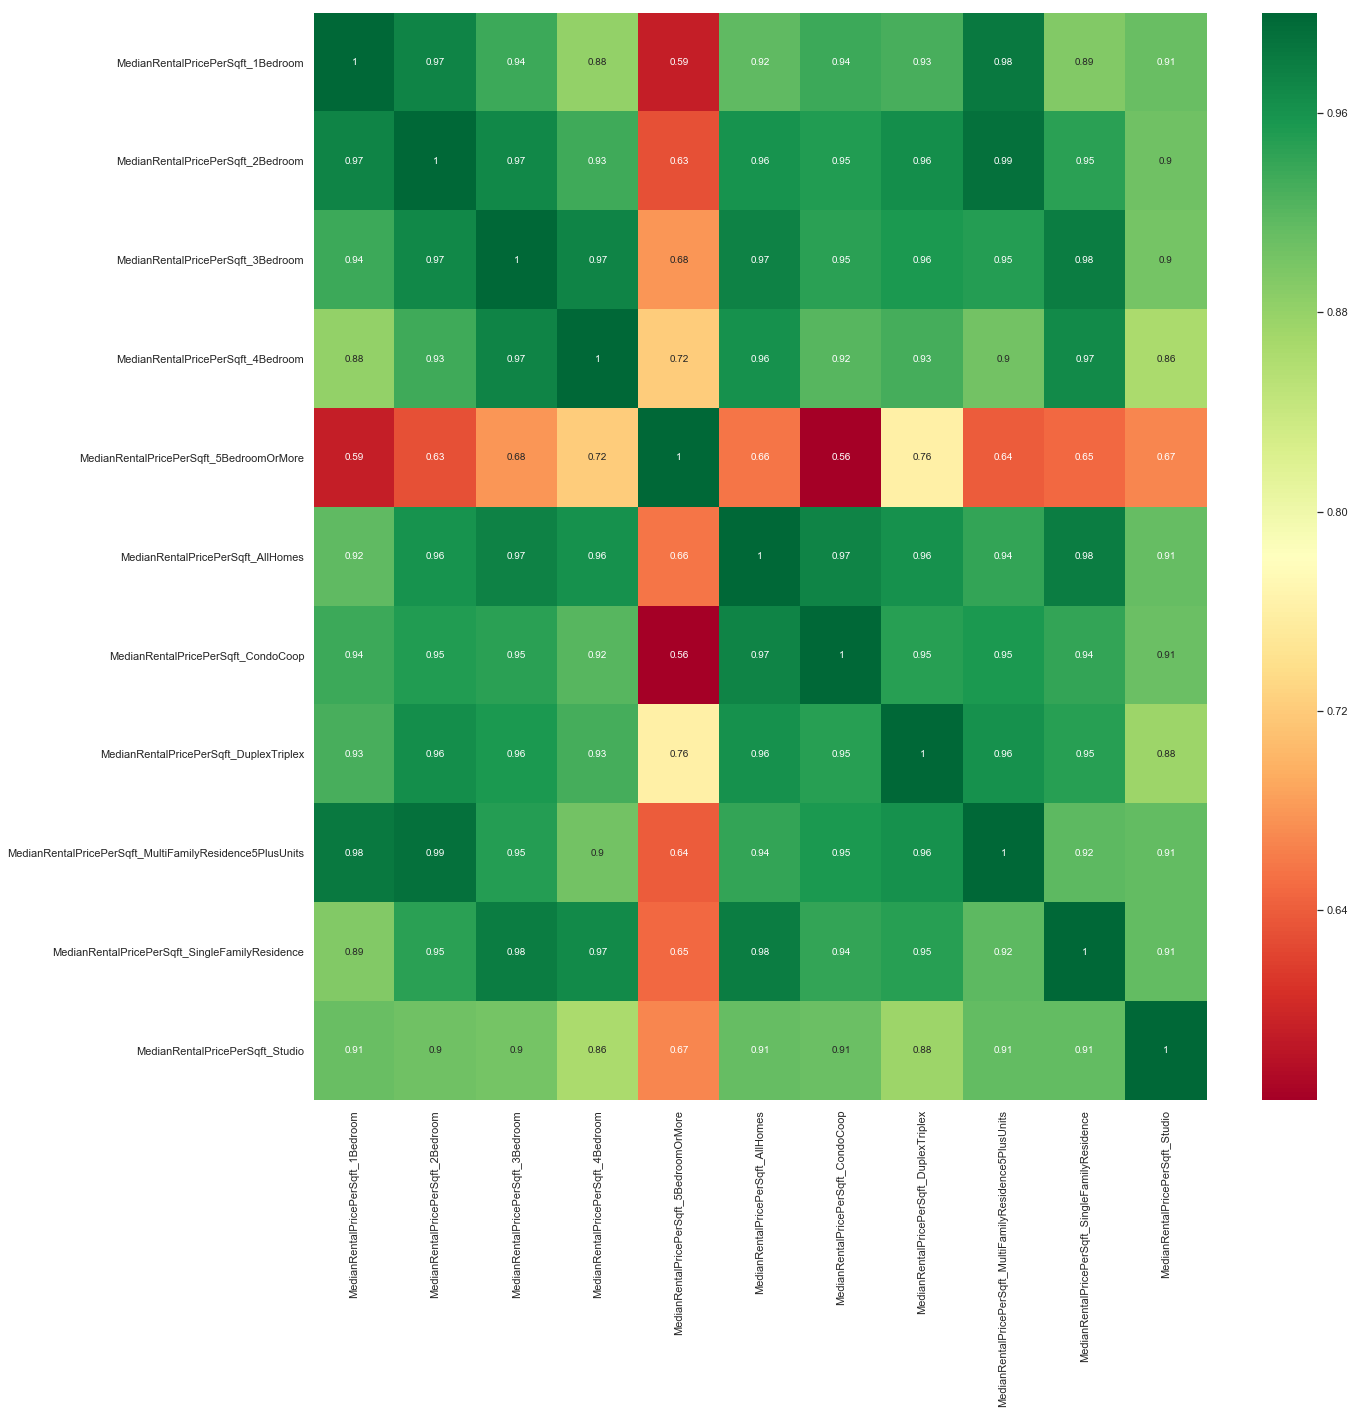

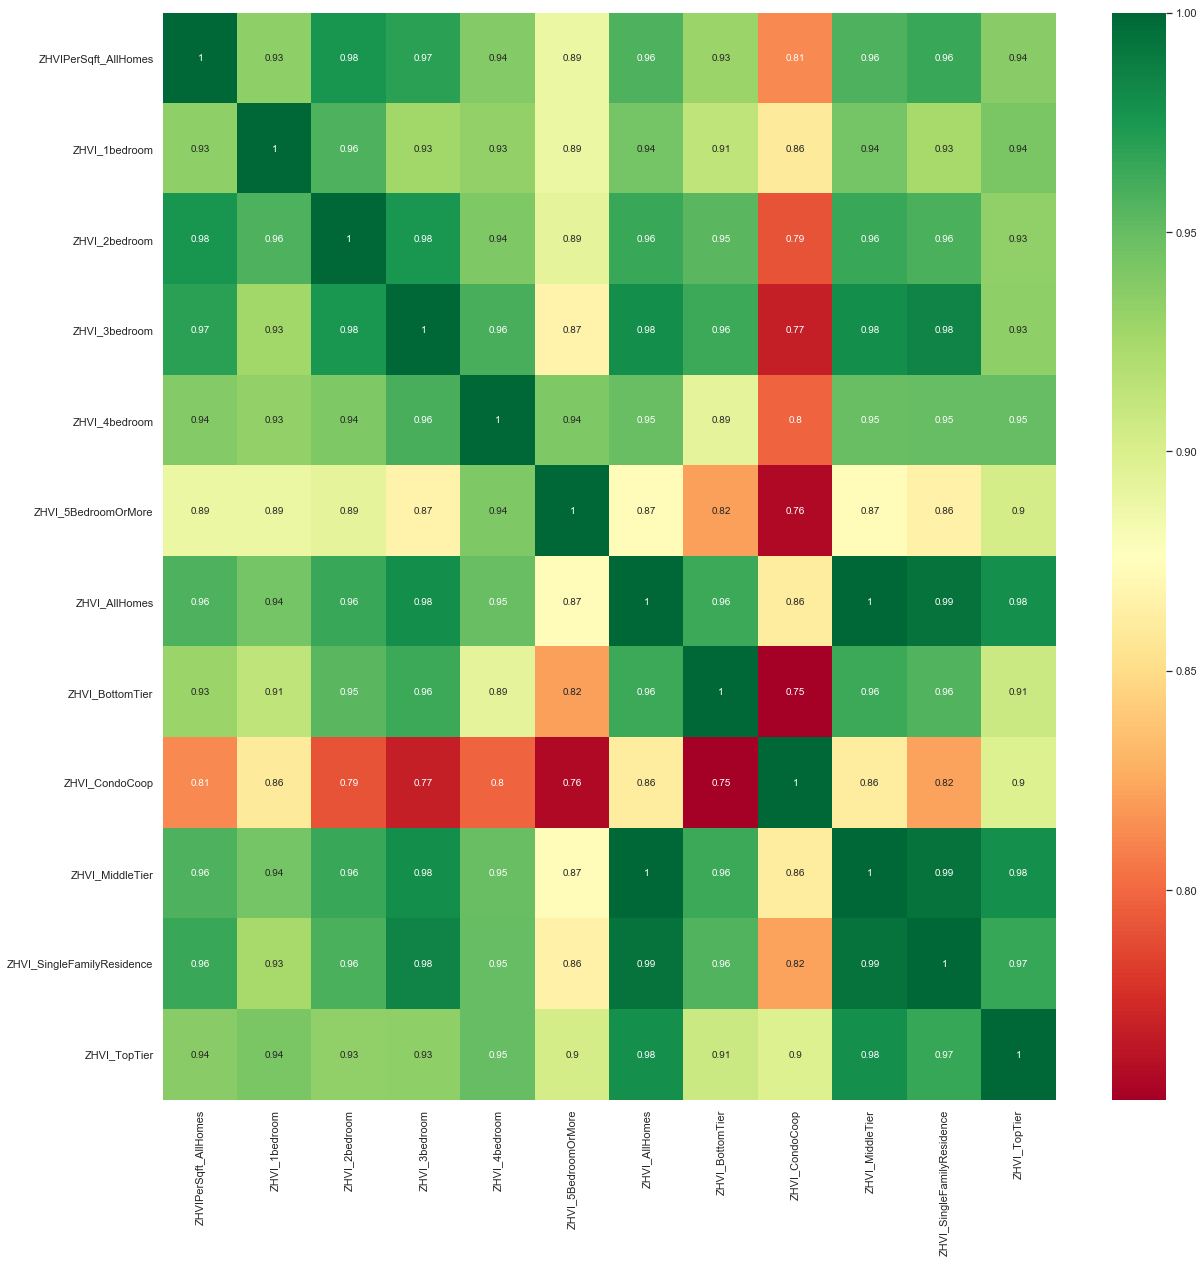

In [8]:
# Highly correlated features
MedianListingPricePerSqft = utils.columns_in(dataframe.columns,'MedianListingPricePerSqft')
MedianListingPrice = utils.columns_in(dataframe.columns,'MedianListingPrice')
MedianRentalPricePerSqft = utils.columns_in(dataframe.columns,'MedianRentalPricePerSqft')
ZHVI = utils.columns_in(dataframe.columns,'ZHVI')
corr_list = [MedianListingPricePerSqft,MedianListingPrice,MedianRentalPricePerSqft,ZHVI]
for item in corr_list:
    utils.corrChart(dataframe,item)

In [9]:
dataframe2010 = dataframe[dataframe.year>2010]

In [10]:
dataframe2010=dataframe2010[dataframe2010.RegionName != 'UnitedStates']

In [11]:
Columns = ['DaysOnZillow_AllHomes',
       'InventorySeasonallyAdjusted_AllHomes', 'InventoryRaw_AllHomes',
       'MedianListingPricePerSqft_AllHomes',
       'MedianListingPrice_AllHomes',
       'MedianPctOfPriceReduction_AllHomes',
       'MedianPriceCutDollar_AllHomes', 
       'MedianRentalPricePerSqft_AllHomes',
       'MedianRentalPrice_AllHomes',
       'PctOfHomesDecreasingInValues_AllHomes', 
       'PctOfHomesIncreasingInValues_AllHomes',
       'PctOfListingsWithPriceReductionsSeasAdj_AllHomes',
       'PctOfListingsWithPriceReductions_AllHomes',
       'PriceToRentRatio_AllHomes', 'Sale_Counts', 'Sale_Counts_Seas_Adj',
       'Sale_Prices', 'ZHVIPerSqft_AllHomes', 'ZRI_AllHomes','year']

In [12]:
x,y=utils.missing_values(dataframe2010[Columns])

Total number of columns:  20
Columns with null values:  13
                                       Total    Percent
PctOfHomesDecreasingInValues_AllHomes   1262  29.458450
PctOfHomesIncreasingInValues_AllHomes   1262  29.458450
Sale_Prices                             1243  29.014939
MedianListingPrice_AllHomes              480  11.204482
Sale_Counts_Seas_Adj                     440  10.270775
Sale_Counts                              440  10.270775
MedianRentalPrice_AllHomes               411   9.593838
MedianRentalPricePerSqft_AllHomes        270   6.302521
MedianListingPricePerSqft_AllHomes       174   4.061625
DaysOnZillow_AllHomes                    134   3.127918
ZRI_AllHomes                             114   2.661064
PriceToRentRatio_AllHomes                109   2.544351
ZHVIPerSqft_AllHomes                      84   1.960784


In [13]:
for item in dataframe2010[Columns]:
    dataframe2010[item] = utils.fill_missing_values(dataframe2010,item)

In [14]:
x,y=utils.missing_values(dataframe2010[Columns])

Total number of columns:  20
Columns with null values:  1
                       Total   Percent
DaysOnZillow_AllHomes     51  1.190476


### For the last month of the data, Days on Zillow is NaN. Replace them with previous year value.

In [15]:
dataframe2010['DaysOnZillow_AllHomes'][dataframe2010['DaysOnZillow_AllHomes'].isna()]=dataframe2010['DaysOnZillow_AllHomes'][dataframe2010['Date']=='2016-12-31']

In [16]:
x,y=utils.missing_values(dataframe2010[Columns])

Total number of columns:  20
Columns with null values:  0
Empty DataFrame
Columns: [Total, Percent]
Index: []


In [17]:
Columns.append('RegionName')
Columns.append('Date')

In [18]:
gbm,df_train,df_test= model.model_train(dataframe2010[Columns],3672)

Training until validation scores don't improve for 1000 rounds.
[100]	valid_0's rmse: 40677.2
[200]	valid_0's rmse: 39613.2
[300]	valid_0's rmse: 39347.8
[400]	valid_0's rmse: 39249.5
[500]	valid_0's rmse: 39154.6
[600]	valid_0's rmse: 39134.3
[700]	valid_0's rmse: 39136.1
[800]	valid_0's rmse: 39121.6
[900]	valid_0's rmse: 39116
[1000]	valid_0's rmse: 39110.9
[1100]	valid_0's rmse: 39106.5
[1200]	valid_0's rmse: 39097.2
[1300]	valid_0's rmse: 39083.6
[1400]	valid_0's rmse: 39086.8
[1500]	valid_0's rmse: 39085.5
[1600]	valid_0's rmse: 39073
[1700]	valid_0's rmse: 39070.5
[1800]	valid_0's rmse: 39078
[1900]	valid_0's rmse: 39077.3
[2000]	valid_0's rmse: 39084.2
[2100]	valid_0's rmse: 39084.5
[2200]	valid_0's rmse: 39075.9
[2300]	valid_0's rmse: 39076.2
[2400]	valid_0's rmse: 39075.7
[2500]	valid_0's rmse: 39079.1
[2600]	valid_0's rmse: 39075.9
Early stopping, best iteration is:
[1694]	valid_0's rmse: 39065.7


In [19]:
states = df_train.columns[20:71]
states_train = df_train[states]
states_test = df_test[states]
states_tr = []
states_te = []

for x in range(len(states_train)):
    if (states_train[x:x+1].sum(axis=1)==0.0)[0]:
            states_tr.append('Wyoming')
    for y in range(len(states_train.columns)):
        if states_train.iloc[x,y]==1.0:
            states_tr.append(states_train.columns[y])

for x in range(len(states_test)):
    if (states_test[x:x+1].sum(axis=1)==0.0)[0]:
            states_te.append('Wyoming')
    for y in range(len(states_test.columns)):
        if states_test.iloc[x,y]==1.0:
            states_te.append(states_test.columns[y])

In [20]:
df_train['States'] = states_tr
df_test['States'] = states_te

In [21]:
df_train['month_year'] = pd.to_datetime(df_train.index).to_period('M')
df_test['month_year'] = pd.to_datetime(df_test.index).to_period('M')

In [22]:
principal = df_train[['States','Sale_Prices']][df_train['month_year']=='2016-12']
principal.index = principal.States
principal=principal.drop(['States'],axis = 'columns')
principal = principal.rename(columns={'Sale_Prices':'Initial_Price'})

In [23]:
final = df_test[['States','Sale_Prices','predicted']][df_test['month_year']=='2017-06']
final['predicted'] = round(final['predicted'],2)
final.index = final.States
final = final.drop(['States'],axis = 'columns')
final = final.rename(columns={'Sale_Prices':'Final_Price'})

In [24]:
investment_return = pd.concat([principal,final],axis=1)
investment_return['Predicted_Profit'] = round(investment_return.predicted - investment_return.Initial_Price,2)
investment_return['Predicted_Profit%'] = round((investment_return.predicted - investment_return.Initial_Price)*100/investment_return.Initial_Price,2)
investment_return['Actual_Profit'] = round(investment_return.predicted - investment_return.Final_Price,2)
investment_return['Actual_Profit%'] = round((investment_return.predicted - investment_return.Final_Price)*100/investment_return.Final_Price,2)
investment_return.sort_values(by=['Predicted_Profit%'], ascending=False)

Initial_Price  Final_Price  predicted  Predicted_Profit  \
States                                                                        
Ohio                     126000.0     128900.0  159600.65          33600.65   
RhodeIsland              206900.0     210000.0  242157.47          35257.47   
SouthCarolina            162000.0     168100.0  181132.09          19132.09   
Louisiana                160800.0     163900.0  179597.10          18797.10   
Nevada                   223400.0     240700.0  247673.91          24273.91   
Kentucky                 143600.0     147100.0  157849.87          14249.87   
Arizona                  222700.0     227000.0  243386.18          20686.18   
Missouri                 158600.0     160700.0  173233.25          14633.25   
Hawaii                   206900.0     210000.0  225440.83          18540.83   
Georgia                  163300.0     171300.0  177350.79          14050.79   
Illinois                 184000.0     190200.0  199262.79          15262.79   
Wyoming                  136900.0     136800.0  148127.25          11227.25   
Washington               306700.0     322000.0  331676.12          24976.12   
Florida                  200300.0     203300.0  216375.48          16075.48   
Wisconsin                164700.0     165200.0  177200.81          12500.81   
Tennessee                160500.0     162800.0  172223.45          11723.45   
Massachusetts            337300.0     349600.0  360037.97          22737.97   
Connecticut              227900.0     225800.0  243196.07          15296.07   
Minnesota                209700.0     216700.0  222375.35          12675.35   
Colorado                 315800.0     324700.0  333955.75          18155.75   
Nebraska                 156800.0     168700.0  165382.18           8582.18   
Virginia                 252800.0     262300.0  266160.46          13360.46   
Oregon                   288800.0     296700.0  301879.07          13079.07   
NorthCarolina            178900.0     182100.0  186787.59           7887.59   
Pennsylvania             154000.0     160200.0  160754.95           6754.95   
NorthDakota              222500.0     224600.0  226036.84           3536.84   
Kansas                   206900.0     210000.0  207460.11            560.11   
NewYork                  265800.0     282400.0  264582.34          -1217.66   
Texas                    204100.0     202100.0  201688.42          -2411.58   
NewHampshire             206900.0     210000.0  203550.03          -3349.97   
Maryland                 253500.0     260900.0  249161.51          -4338.49   
California               431700.0     452400.0  422737.21          -8962.79   
NewJersey                278700.0     264900.0  272293.36          -6406.64   
Arkansas                 137000.0     135200.0  133504.81          -3495.19   
Idaho                    199600.0     203300.0  193835.91          -5764.09   
Oklahoma                 132000.0     140600.0  128040.51          -3959.49   
Alaska                   309100.0     307000.0  299756.99          -9343.01   
Delaware                 220400.0     220900.0  213264.26          -7135.74   
Vermont                  206900.0     210000.0  198635.40          -8264.60   
NewMexico                186500.0     197700.0  178714.35          -7785.65   
DistrictofColumbia       534900.0     528700.0  507877.23         -27022.77   
WestVirginia             144000.0     143700.0  136228.32          -7771.68   
SouthDakota              206900.0     210000.0  191373.61         -15526.39   
Iowa                     206900.0     210000.0  190722.39         -16177.61   
Wyoming                  240700.0     229600.0  219068.15         -21631.85   
Maine                    206900.0     210000.0  187088.92         -19811.08   
Montana                  248200.0     252200.0  219665.81         -28534.19   
Utah                     257200.0     266400.0  224385.73         -32814.27   
Mississippi              206900.0     210000.0  179674.98         -272

A 24% gain in the Prices in the State of Ohio.